In [37]:
import pyterrier as pt
import pandas as pd
from LLmsfJiT import read_trec_queries
import itertools
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kendalltau

In [3]:
pt.init()

PyTerrier 0.10.0 has loaded Terrier 5.8 (built by craigm on 2023-11-01 18:05) and terrier-helper 0.0.8

No etc/terrier.properties, using terrier.default.properties for bootstrap configuration.


In [4]:
def remap_to_bin(row: pd.core.series.Series):
    if row.label == 2:
        return 1
    else:
        return row.label

In [28]:
topics = pd.DataFrame(list(read_trec_queries("../rel_files/queries.txt").items()), columns=["qid", "query"])
topics["qid"] = topics["qid"].astype(str)

qrels = pd.read_csv("../rel_files/rel_table_qrels.txt", delimiter="\t", names=["qid", "iteration", "docno", "label"]).drop(columns=["iteration"])
qrels["qid"] = qrels["qid"].astype(str)
qrels["label"] = qrels["label"].astype(int)
qrels["label"] = qrels.apply(remap_to_bin, axis=1)

qrels_gpt = pd.read_csv("../gpt_judgements/rel_table_qrels.txt", delimiter="\t", names=["qid", "iteration", "docno", "label"]).drop(columns=["iteration"])
qrels_gpt["qid"] = qrels_gpt["qid"].astype(str)
qrels_gpt["label"] = qrels_gpt["label"].astype(int)
qrels_gpt["label"] = qrels_gpt.apply(remap_to_bin, axis=1)


In [29]:
index = pt.IndexFactory.of("../pyterrier_indexes/single_field_index_topics-20/data.properties")
tf_idf = pt.BatchRetrieve(index, wmodel="TF_IDF")
bm25 = pt.BatchRetrieve(index, wmodel="BM25")
DLM = pt.BatchRetrieve(index, wmodel="DirichletLM")

ex = pt.Experiment([tf_idf, bm25, DLM], topics, qrels, eval_metrics=["map", "P_5", "P_10",  "ndcg_cut_5", "ndcg_cut_10"])
ex

,name,map,P_5,P_10,ndcg_cut_5,ndcg_cut_10
0,BR(TF_IDF),0.417092,0.543333,0.500,0.553362,0.520714
1,BR(BM25),0.415749,0.536667,0.495,0.541956,0.512114
2,BR(DirichletLM),0.377333,0.460000,0.440,0.462417,0.448721


In [30]:
experiments = []
for x in range(topics["qid"].nunique()):
    ex = pt.Experiment([tf_idf], topics.iloc[x].to_frame().T, qrels, eval_metrics=["map", "P_5", "P_10",  "ndcg_cut_5", "ndcg_cut_10"])
    experiments.append(ex)
experiment_df = pd.concat(experiments)
models = experiment_df["name"].unique()

index_ls = []
for q in topics["qid"]:
    index_ls.extend(list(zip(itertools.repeat(q), models) ))

index = pd.MultiIndex.from_tuples(index_ls, names=["qid", "model"])
experiment_df.index = index

experiment_df.drop(columns=["name"], inplace=True)

In [31]:
def generate_experiments_from_index(index_path, topics, qrels):

    index = pt.IndexFactory.of(index_path)
    tf_idf = pt.BatchRetrieve(index, wmodel="TF_IDF")
    # bm25 = pt.BatchRetrieve(index, wmodel="BM25")
    # DLM = pt.BatchRetrieve(index, wmodel="DirichletLM")

    experiments = []
    for x in range(topics["qid"].nunique()):
        ex = pt.Experiment([tf_idf], topics.iloc[x].to_frame().T, qrels, eval_metrics=["map", "P_5", "P_10",  "ndcg_cut_5", "ndcg_cut_10"])
        experiments.append(ex)
    experiment_df = pd.concat(experiments)
    models = experiment_df["name"].unique()

    index_ls = []
    for q in topics["qid"]:
        index_ls.extend(list(zip(itertools.repeat(q), models) ))

    index = pd.MultiIndex.from_tuples(index_ls, names=["qid", "model"])
    experiment_df.index = index

    experiment_df.drop(columns=["name"], inplace=True)
    return experiment_df

In [32]:
ex_human = generate_experiments_from_index("../pyterrier_indexes/single_field_index_topics-20/data.properties", topics, qrels)

In [33]:
ex_gpt = generate_experiments_from_index("../pyterrier_indexes/single_field_index_topics-20/data.properties", topics, qrels_gpt)

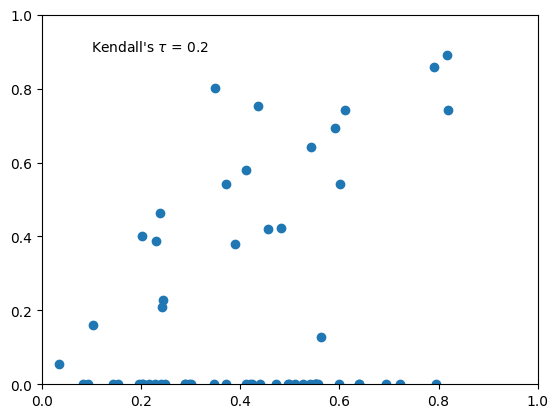

In [43]:
kt = round(kendalltau(ex_human["map"], ex_gpt["map"]).pvalue, 2)
plt.scatter(ex_human["map"], ex_gpt["map"])
plt.text(0.1, 0.9, f"Kendall's $\\tau$ = {kt}")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

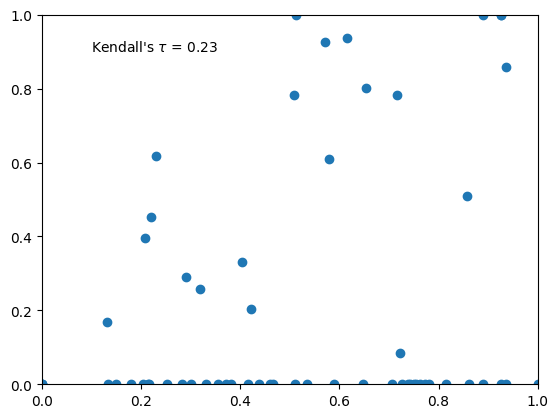

In [44]:
kt = round(kendalltau(ex_human["ndcg_cut_10"], ex_gpt["ndcg_cut_10"]).pvalue, 2)
plt.scatter(ex_human["ndcg_cut_10"], ex_gpt["ndcg_cut_10"])
plt.text(0.1, 0.9, f"Kendall's $\\tau$ = {kt}")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()